In [1]:
import numpy as np

def forward(X, W1, b1, W2, b2):
    # sigmoid
    # Z = 1 / (1 + np.exp(-( X.dot(W1) + b1 )))

    # relu
    Z = X.dot(W1) + b1
    Z[Z < 0] = 0

    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y, Z

def derivative_w2(Z, T, Y):
    return Z.T.dot(Y - T)

def derivative_b2(T, Y):
    return (Y - T).sum(axis=0)

def derivative_w1(X, Z, T, Y, W2, act_function='relu'):
    if act_function == 'sigmoid':
        return X.T.dot( ( ( Y-T ).dot(W2.T) * ( Z*(1 - Z) ) ) ) # for sigmoid
    return X.T.dot( ( ( Y-T ).dot(W2.T) * (Z > 0) ) ) # for relu

def derivative_b1(Z, T, Y, W2, act_function='relu'):
    if act_function == 'sigmoid':
        return (( Y-T ).dot(W2.T) * ( Z*(1 - Z) )).sum(axis=0) # for sigmoid
    return (( Y-T ).dot(W2.T) * (Z > 0)).sum(axis=0) # for relu


In [2]:
from util import get_normalized_data, error_rate, cost, y2indicator
import matplotlib.pyplot as plt

max_iter = 10
print_period = 100

X, Y = get_normalized_data()
reg = 0.01

Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

M = 300
K = 10
W1_0 = np.random.randn(D, M) / np.sqrt(D)
b1_0 = np.zeros(M)
W2_0 = np.random.randn(M, K) / np.sqrt(M)
b2_0 = np.zeros(K)

W1 = W1_0.copy()
b1 = b1_0.copy()
W2 = W2_0.copy()
b2 = b2_0.copy()

# 1st moment
mW1 = 0
mb1 = 0
mW2 = 0
mb2 = 0

# 2nd moment
vW1 = 0
vb1 = 0
vW2 = 0
vb2 = 0

# hyperparams
lr0 = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 1e-8

Reading in and transforming data...


Cost at iteration i=0, j=0: 2060.395325
Error rate: 0.67
Cost at iteration i=1, j=0: 227.072054
Error rate: 0.066
Cost at iteration i=2, j=0: 187.475606
Error rate: 0.059
Cost at iteration i=3, j=0: 166.782665
Error rate: 0.048
Cost at iteration i=4, j=0: 152.845955
Error rate: 0.045
Cost at iteration i=5, j=0: 145.531318
Error rate: 0.041
Cost at iteration i=6, j=0: 140.263418
Error rate: 0.04
Cost at iteration i=7, j=0: 138.556144
Error rate: 0.039
Cost at iteration i=8, j=0: 136.776992
Error rate: 0.038
Cost at iteration i=9, j=0: 135.608318
Error rate: 0.036
Final error rate: 0.035


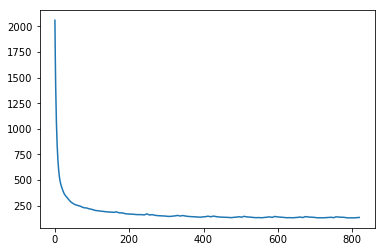

In [3]:
# 1. Adam
loss_adam = []
err_adam = []
t = 1
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

        # updates
        # gradients
        gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
        gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
        gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
        gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1

        # new m
        mW1 = beta1 * mW1 + (1 - beta1) * gW1
        mb1 = beta1 * mb1 + (1 - beta1) * gb1
        mW2 = beta1 * mW2 + (1 - beta1) * gW2
        mb2 = beta1 * mb2 + (1 - beta1) * gb2

        # new v
        vW1 = beta2 * vW1 + (1 - beta2) * gW1 * gW1
        vb1 = beta2 * vb1 + (1 - beta2) * gb1 * gb1
        vW2 = beta2 * vW2 + (1 - beta2) * gW2 * gW2
        vb2 = beta2 * vb2 + (1 - beta2) * gb2 * gb2

        # bias correction
        correction1 = 1 - beta1 ** t
        hat_mW1 = mW1 / correction1
        hat_mb1 = mb1 / correction1
        hat_mW2 = mW2 / correction1
        hat_mb2 = mb2 / correction1

        correction2 = 1 - beta2 ** t
        hat_vW1 = vW1 / correction2
        hat_vb1 = vb1 / correction2
        hat_vW2 = vW2 / correction2
        hat_vb2 = vb2 / correction2

        # update t
        t += 1

        # apply updates to the params
        W1 = W1 - lr0 * hat_mW1 / np.sqrt(hat_vW1 + eps)
        b1 = b1 - lr0 * hat_mb1 / np.sqrt(hat_vb1 + eps)
        W2 = W2 - lr0 * hat_mW2 / np.sqrt(hat_vW2 + eps)
        b2 = b2 - lr0 * hat_mb2 / np.sqrt(hat_vb2 + eps)
        pY, _ = forward(Xtest, W1, b1, W2, b2)
        l = cost(pY, Ytest_ind)
        loss_adam.append(l)


        if j % print_period == 0:
            print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))
            err = error_rate(pY, Ytest)
            err_adam.append(err)
            print("Error rate:", err)

pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate:", error_rate(pY, Ytest))

plt.plot(loss_adam, label='adam')
plt.show()

Cost at iteration i=0, j=0: 2332.023477
Error rate: 0.866
Cost at iteration i=1, j=0: 234.603735
Error rate: 0.063
Cost at iteration i=2, j=0: 202.312112
Error rate: 0.058
Cost at iteration i=3, j=0: 184.050144
Error rate: 0.05
Cost at iteration i=4, j=0: 174.149690
Error rate: 0.046
Cost at iteration i=5, j=0: 162.278285
Error rate: 0.046
Cost at iteration i=6, j=0: 156.562857
Error rate: 0.044
Cost at iteration i=7, j=0: 151.220040
Error rate: 0.039
Cost at iteration i=8, j=0: 149.913918
Error rate: 0.038
Cost at iteration i=9, j=0: 149.632428
Error rate: 0.036
Final error rate: 0.038


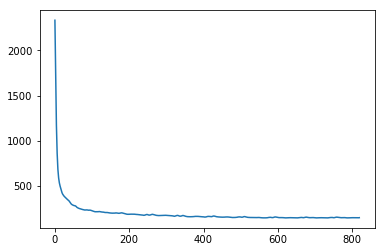

In [4]:
# 2. RMSprop with momentum
W1 = W1_0.copy()
b1 = b1_0.copy()
W2 = W2_0.copy()
b2 = b2_0.copy()
loss_rms = []
err_rms = []

# comparable hyperparameters for fair comparison
lr0 = 0.001
mu = 0.9
decay_rate = 0.999
eps = 1e-8

# rmsprop cache
cache_W2 = 1
cache_b2 = 1
cache_W1 = 1
cache_b1 = 1

# momentum
dW1 = 0
db1 = 0
dW2 = 0
db2 = 0

for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

        # updates
        gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
        cache_W2 = decay_rate*cache_W2 + (1 - decay_rate)*gW2*gW2
        dW2 = mu * dW2 + (1 - mu) * lr0 * gW2 / (np.sqrt(cache_W2) + eps)
        W2 -= dW2

        gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
        cache_b2 = decay_rate*cache_b2 + (1 - decay_rate)*gb2*gb2
        db2 = mu * db2 + (1 - mu) * lr0 * gb2 / (np.sqrt(cache_b2) + eps)
        b2 -= db2

        gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
        cache_W1 = decay_rate*cache_W1 + (1 - decay_rate)*gW1*gW1
        dW1 = mu * dW1 + (1 - mu) * lr0 * gW1 / (np.sqrt(cache_W1) + eps)
        W1 -= dW1

        gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1
        cache_b1 = decay_rate*cache_b1 + (1 - decay_rate)*gb1*gb1
        db1 = mu * db1 + (1 - mu) * lr0 * gb1 / (np.sqrt(cache_b1) + eps)
        b1 -= db1
        
        pY, _ = forward(Xtest, W1, b1, W2, b2)
        l = cost(pY, Ytest_ind)
        loss_rms.append(l)

        if j % print_period == 0:
            print("Cost at iteration i=%d, j=%d: %.6f" % (i, j, l))
            err = error_rate(pY, Ytest)
            err_rms.append(err)
            print("Error rate:", err)

pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate:", error_rate(pY, Ytest))
plt.plot(loss_rms, label='rmsprop')
plt.show()

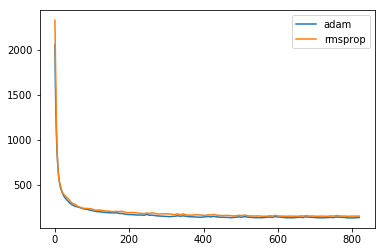

In [5]:
plt.plot(loss_adam, label='adam')
plt.plot(loss_rms, label='rmsprop')
plt.legend()
plt.show()